In [1]:
from dynamical_system.modulation import *
from environment import *
from controller import *
from kernel import *
from visualize_samples import *
import sys

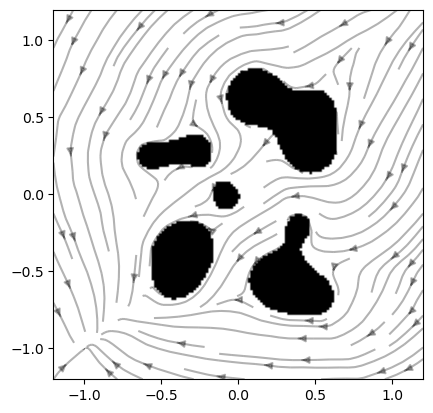

In [34]:
# visualize DS with different target
target = [-1., -1.]
seed = 17 #5 13 17

import random
np.random.seed(seed)
random.seed(seed)

env = RBF2dGymEnv(time_limit=500, oob_termination=False, use_lidar=False)
ds_controller = DSController()
env_kernel = RBF2dEnvKernelNormal()

# sample 
env_kernel.sample_prior() # sample collision points
env.reset(obs_override=env_kernel.value) # set sampled collision points
env.target_pos = target
ds_controller.modulator.set_arena(env.arena, target=target)
# # get a single traj
# traj = ds_controller.get_trajectory(env)
# plt.imshow(env.arena.occ_grid, origin='lower', extent=[-1.2, 1.2, -1.2, 1.2], cmap='binary')

# visualize DS
def plot_ds(env, XY, UV):
    res = env.arena.grid_res
    bd = env.arena.grid_bd
    plt.imshow(env.arena.occ_grid, origin='lower', extent=[-bd, bd, -bd, bd], cmap='binary')    
    plt.streamplot(XY[:, 0].reshape(res, res), XY[:, 1].reshape(res, res), UV[:, 0].reshape(res, res), UV[:, 1].reshape(res, res), color=[0, 0, 0, 0.3])

x = np.linspace(-env.arena.grid_bd, env.arena.grid_bd, env.arena.grid_res)
y = np.linspace(-env.arena.grid_bd, env.arena.grid_bd, env.arena.grid_res)
X, Y = np.meshgrid(x, y)
XY=np.array([X.flatten(),Y.flatten()]).T
UV = np.zeros(XY.shape)
for i in range(len(XY)):
    UV[i] = ds_controller.modulator.modulate(XY[i])
# plt.streamplot(XY[:, 0].reshape(res, res), XY[:, 1].reshape(res, res), UV[:, 0].reshape(res, res), UV[:, 1].reshape(res, res))
# plt.plot(traj[:, 0], traj[:, 1])
# plt.scatter(env.arena.points[:, 0], env.arena.points[:, 1])
# plt.show()
plot_ds(env, XY, UV)

In [35]:
# rollouts from grid starts
sample_res = 32
a = np.linspace(-1.0, 1.0, sample_res)
b = np.linspace(-1.0, 1.0, sample_res)
A, B = np.meshgrid(a, b)
AB = np.array([A.flatten(), B.flatten()]).T

traj_data = []
traj_lens = []
for start in AB: 
    try: # at least one traj will give error when the start and the goal coincide
        env.sim.reset(start)
        env.t = 0
        traj = ds_controller.get_trajectory(env)
        traj_lens.append(len(traj))
        traj_data.append(traj)
    except: # the reset position is not in the free space
        continue

Traceback (most recent call last):
  File "/home/felixw/interactive_gpt/RoCUS/navigation/controller.py", line 50, in get_trajectory
    d = self.modulator.modulate(s)
  File "/home/felixw/interactive_gpt/RoCUS/navigation/dynamical_system/modulation.py", line 57, in modulate
    d = self.modulation_HBS(x, orig_ds)
  File "/home/felixw/interactive_gpt/RoCUS/navigation/dynamical_system/modulation.py", line 51, in modulation_HBS
    avg_ds_dir = get_weighted_sum(ref_dir=x_dot, dirs=x_dot_mods, weights=weights)
  File "/home/felixw/interactive_gpt/RoCUS/navigation/dynamical_system/modulation.py", line 222, in get_weighted_sum
    assert np.linalg.norm(ref_dir) > 0, 'ref_dir cannot be 0'
AssertionError: ref_dir cannot be 0


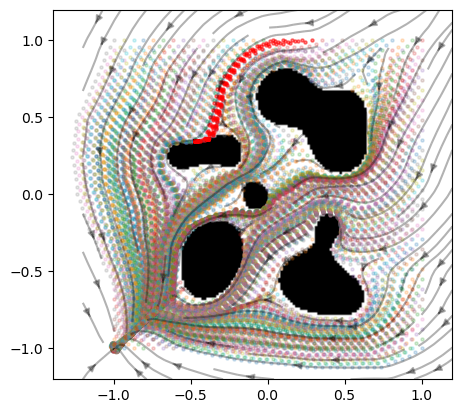

In [36]:
# investigate long traj
plot_ds(env, XY, UV)
for traj in traj_data:
# while True:
#     traj = random.choice(traj_data)
    if len(traj) < 500:
        plt.scatter(traj[::1, 0], traj[::1, 1], alpha=0.2, s=5)
    else:
        plt.scatter(traj[::1, 0], traj[::1, 1], alpha=0.5, c='r', s=5)
#         break

(array([213., 472., 139.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.]),
 array([  2.  ,  26.95,  51.9 ,  76.85, 101.8 , 126.75, 151.7 , 176.65,
        201.6 , 226.55, 251.5 , 276.45, 301.4 , 326.35, 351.3 , 376.25,
        401.2 , 426.15, 451.1 , 476.05, 501.  ]),
 <a list of 20 Patch objects>)

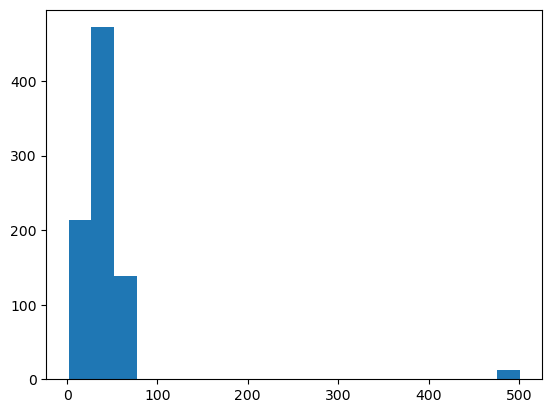

In [37]:
plt.hist(traj_lens, bins=20)

In [38]:
def get_boundary_and_bin_size():
    res = 100
    xmin = -1.2
    xmax = 1.2
    ymin = -1.2
    ymax = 1.2
    xbin = (xmax - xmin) / res
    ybin = (ymax - ymin) / res
    return xmin, xmax, ymin, ymax, xbin, ybin, res

def tokenize(pos):
    # input pos array of (x, y)
    # output the token value
    xmin, xmax, ymin, ymax, xbin, ybin, res = get_boundary_and_bin_size()
    mins, maxs, bins = (xmin, ymin), (xmax, ymax), (xbin, ybin)
    idxs = []
    for col, _ in enumerate(['xs', 'ys']):
        mask_1 = pos[:, col] <= mins[col]
        mask_2 = pos[:, col] >= maxs[col]
        idx = (pos[:, col]-mins[col]) // bins[col]
        idx[mask_1] = 0
        idx[mask_2] = res-1
        idxs.append(idx)

    token = idxs[0] + idxs[1]*res
    return token

def detokenize(token):
    # input integer token
    # output the (x, y) coordinate
    xmin, xmax, ymin, ymax, xbin, ybin, res = get_boundary_and_bin_size()
    y_idx = token // res
    x_idx = token % res
    return np.vstack((x_idx*xbin+xmin, y_idx*ybin+ymin)).T

In [39]:
# pad traj
padded_traj_data = []
for traj in traj_data:
    if len(traj) < 128:
#     assert len(traj) < 128, 'traj length longer than 128'
        padded_traj = np.pad(traj, pad_width=((0, 128-len(traj)), (0, 0)), mode='edge')
    else:
        padded_traj = traj[:128, :]
    padded_traj_data.append(padded_traj)
    
padded_traj_data = np.stack(padded_traj_data)
padded_traj_data.shape

(836, 128, 2)

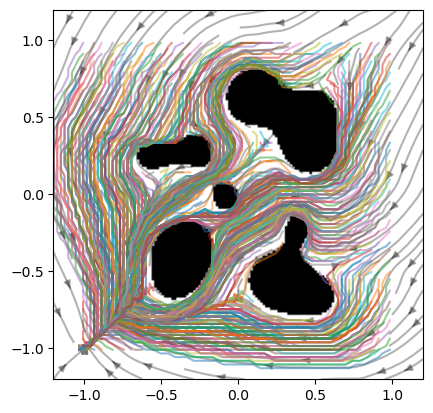

In [40]:
# tokenize trajs
tokens = tokenize(padded_traj_data.reshape((-1, 2)))
tokenized_traj = detokenize(tokens).reshape((-1, 128, 2))
tokenized_traj.shape

# visualize tokenized traj
plot_ds(env, XY, UV)
for traj in tokenized_traj:
    if len(traj) < 500:
        plt.plot(traj[::1, 0], traj[::1, 1], alpha=0.5)
    else:
        plt.plot(traj[::1, 0], traj[::1, 1], alpha=0.5, c='r')


In [41]:
np.save('reach_ll.npy', padded_traj_data)

In [42]:
ds_field = np.stack((XY, UV))
np.save('ds_field_ll.npy', ds_field)